# Bank Predictioins

# Step 2: Discover

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

## Obtaining the Data

In [2]:
import sys

sys.path.insert(0, '/scripts/')
from scripts.helpers import load_data, find_outliers, classifier_categorical_variance, plot_success_rates

In [3]:
path = './raw_data/'
file = 'bank-full.csv'
bank_data = load_data(path=path, file=file, verbose=True, sep=';')

--------------------------------bank-full shape---------------------------------
                                  (41188, 21)                                   


----------------------------bank-full's column types----------------------------
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


---------------------------bank-full first five rows----------------------------
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic

## Cleaning the Data

There is an incredibly small probability that any rows which are exactly the same represent two distinct clients, so I will be dropping any duplicated rows.

In [4]:
bank_data.drop_duplicates(inplace=True)
bank_data.shape

(41176, 21)

In [5]:
bank_data.dropna(inplace=True)
bank_data.shape

(41176, 21)

In [6]:
bank_data.drop('duration', axis=1, inplace=True)
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Please refer to my discussion [here](./01_Define.ipynb#Dropping-'duration') for an explanation as to why I am dropping the column "duration." 

## Exploring the Data

The first thing I want to do is to compare the counts of whether a client subscribed or not to a term deposit. This is to make sure that both subscribed and not subscribed will be equally represented in the model.

Rejection rate: 0.887%
Subscription rate: 0.113%
Number of Subscribers: 4639
Number of Rejections: 36537


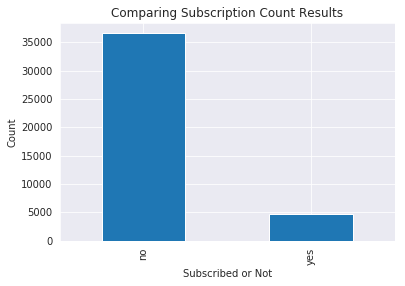

In [7]:
target_col = bank_data['y']
count = target_col.value_counts()

sns.set_style("darkgrid")
ax = count.plot(kind='bar')
ax.set_ylabel("Count")
ax.set_xlabel("Subscribed or Not")
ax.set_title("Comparing Subscription Count Results")



print(f'Rejection rate: {count["no"] / count.sum():.3f}%')
print(f'Subscription rate: {count["yes"] / count.sum():.3f}%')
print(f'Number of Subscribers: {count["yes"]}')
print(f'Number of Rejections: {count["no"]}')

As expected for a marketing campaign, the number of rejections clearly outweigh the number of people who subscribed to a term deposit with roughly 89% of the data being rejections. To get a more accurate model, it would be best to make it so that both the positive and negative results are roughly equivalent. I can achieve this by either downsampling the rejections or upsampling the subscriptions. I will be upsampling the subscriptions because there would be too large of a loss of information if I took a random sample of the rejections. The method I will be using to upsample the data is [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE), and it will be applied to the training data after it has been preprocessed and split into training and validation data in the next notebook.

### Exploring the Data, Categorical Features

In [8]:
cat_cols = [x for x in bank_data.columns if bank_data[x].dtype==object and x != 'y']

In [9]:
cat_variances = classifier_categorical_variance(bank_data, cat_cols, 'y')
cat_variances

,no,yes
poutcome,0.0964304,0.0964304
month,0.0359273,0.0359273
job,0.00542325,0.00542325
contact,0.00451867,0.00451867
default,0.0042027,0.00298509
education,0.00213338,0.00213338
marital,0.00062314,0.00062314
day_of_week,7.72104e-05,7.72104e-05
housing,2.03453e-05,2.03453e-05
loan,7.79057e-06,7.79057e-06


As we can see, there is a greater variety in outcome rate for variables *poutcome* and *month* whereas features *day_of_week*, *housing*, and *loan* don't vary much at all. The variables with low variance will be quite useless when doing the analysis and can be safely removed from the dataset. 

I will be taking a closer look with some plots for *poutcome* and *month* to better understand how it affects whether or not a client subscribes.

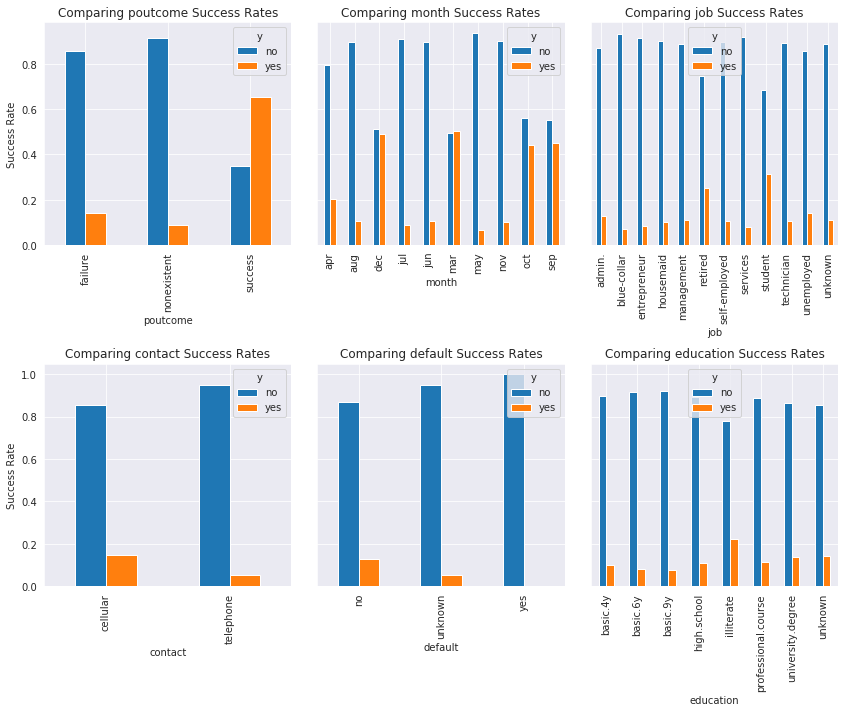

In [10]:
plot_success_rates(bank_data, cat_variances.index[:6], 'y', 3)

There are a few oddities that I would like to look into. Notably, I want to see how many of the clients have defaulted, how many of the clients are retired, how many of the clients are students, and how many are illiterate. These all have abnormal success rates, and I want to see if it was due to being an abnormally small amount of the data.

In [11]:
print(f"Number of Defaulted clients: {bank_data[bank_data['default']=='yes'].shape[0]}")
print(f"Number of Student clients: {bank_data[bank_data['job']=='student'].shape[0]}")
print(f"Number of Retired clients: {bank_data[bank_data['job']=='retired'].shape[0]}")
print(f"Number of Retired clients: {bank_data[bank_data['education']=='illiterate'].shape[0]}")

Number of Defaulted clients: 3
Number of Student clients: 875
Number of Retired clients: 1718
Number of Retired clients: 18


### Exploring the Data, Numeric Features

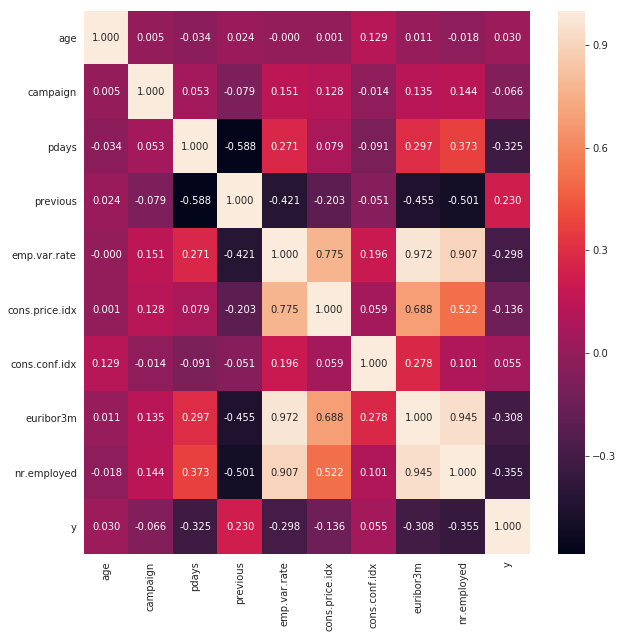

In [130]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

bank_data['y'] = le.fit_transform(bank_data.y)
# test = bank_data.pdays.replace(to_replace=999, value=20)
num_bank_data = bank_data[[x for x in bank_data.columns if x not in cat_cols or x =='y']].copy()

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(num_bank_data.corr(), annot=True, fmt='.3f')

A lot of these features are almost perfectly correlated with another feature. This might lead to overfitting and unstable coefficients in any linear models I use. I'll be checking out their [Variance Inflation Factor (VIF)](https://en.wikipedia.org/wiki/Variance_inflation_factor) scores to obtain a more accurate view of how bad the multicollinearity is in the numerical columns. A good rule of thumb throughout the statistical community seems to be keeping the VIF score under 5.

In [87]:
from statsmodels.tools.tools import add_constant
# Setting the constant term for the VIF calculation
vif_data = add_constant(num_bank_data)

pd.Series([variance_inflation_factor(vif_data.values, i) 
               for i in range(vif_data.shape[1])], 
              index=vif_data.columns)

/home/kyle/DSDJ/Module4/bank-predictions/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const             528527.272623
age                    1.018919
campaign               1.034009
pdays                  1.681787
previous               1.799862
emp.var.rate          33.103632
cons.price.idx         6.349466
cons.conf.idx          2.655055
euribor3m             64.335172
nr.employed           31.711183
y                      1.215413
dtype: float64

Seeing values for VIF above 30 is initially concerning, but I'll be able to ignore this high multicollinearity due to the low VIF value for the target variable *y*. Features can have a high multicollinearity with other features so long as they don't create a high multicollinearity in the target variable. For more areas in which multicollinearity can be safely ignored, see [this](https://statisticalhorizons.com/multicollinearity) informative article.

In [131]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
interactions = pd.DataFrame(poly.fit_transform(num_bank_data.drop('y', axis=1)), columns=poly.get_feature_names(num_bank_data.drop('y', axis=1).columns))

In [136]:
interactions['y'] = num_bank_data['y'].copy()
interactions.loc[:, abs(interactions.corr()['y']) > .15].head()

,pdays,previous,emp.var.rate,euribor3m,nr.employed,age previous,age emp.var.rate,age euribor3m,campaign previous,campaign emp.var.rate,...,emp.var.rate cons.conf.idx,emp.var.rate euribor3m,emp.var.rate nr.employed,cons.price.idx euribor3m,cons.price.idx nr.employed,cons.conf.idx euribor3m,euribor3m^2,euribor3m nr.employed,nr.employed^2,y
0,999.0,0.0,1.1,4.857,5191.0,0.0,61.6,271.992,0.0,1.1,...,-40.04,5.3427,5710.1,456.528858,487922.854,-176.7948,23.590449,25212.687,26946481.0,0.0
1,999.0,0.0,1.1,4.857,5191.0,0.0,62.7,276.849,0.0,1.1,...,-40.04,5.3427,5710.1,456.528858,487922.854,-176.7948,23.590449,25212.687,26946481.0,0.0
2,999.0,0.0,1.1,4.857,5191.0,0.0,40.7,179.709,0.0,1.1,...,-40.04,5.3427,5710.1,456.528858,487922.854,-176.7948,23.590449,25212.687,26946481.0,0.0
3,999.0,0.0,1.1,4.857,5191.0,0.0,44.0,194.280,0.0,1.1,...,-40.04,5.3427,5710.1,456.528858,487922.854,-176.7948,23.590449,25212.687,26946481.0,0.0
4,999.0,0.0,1.1,4.857,5191.0,0.0,61.6,271.992,0.0,1.1,...,-40.04,5.3427,5710.1,456.528858,487922.854,-176.7948,23.590449,25212.687,26946481.0,0.0


Adding in the 2nd degree interactions creates a lot more features that correlate well with the target variable. I'll attempt utilizing these in the rest of the analysis, and I will adjust my Preprocessor appropriately to handle this for me.

## Establishing a Baseline Outcome

I would create a simplistic model representing random guesses to create a naive value for my metric so that I could obtain a reference for how well the models actually perform. But, the metric I'm using has that built in to the formulation. For AUC, a value of .5 corresponds to a model which is just randomly guessing positive and negative outcomes.

## Hypothesizing Solutions

The first model that I will be utilizing for this analysis is a simple **Logistic Regression**. This is generally how a company might attempt the problem without needing to get into more complex machine learning algorithms. It is a quick and easy model to use, and it might end up meeting all the requirements for the problem at hand. Simpler does not mean worse by any means. The second model I will be trying out is **Support Vector Machine (SVM)**. SVM is a robust training algorithm that can be adapted to just about any classification problem by modifying the kernel function used to build the model. The last model I'll be using is a **Random Forest Classifier**. The Random Forest is an incredibly robust algorithm which can be tuned to create accurate models by utilizing weak learners. The robustness of the model makes it much easier to create a generalized model.

In this analysis, I expect the numeric features to provide a greater amount of useful information because they can better track how the economy is doing at the time of calling clients.